# Tanzania Water Wells Analysis

## Introduction
In this project our team build a classifier that predicted the condition of water wells in Tanzania. The classifier's we decided to go with were logistic regression and a decision tree classifier. We also tuned our decision tree with hyperparameters. Our stakeholders for this project is the Government of Tanzania as we are aiming to minimize the Type 1 error and false positives; in this case minimizing identifying wells as functioning when they are actually not functioning. We decided to focus on this because we believe that those in need of water resources would much rather be able to still receive those resources despite us identifying the well as non functioning. To state that a well is functioning and have people not be able to receive water would be extremely alarming. 

# Table of Contents

### <b>Introduction<b>
### <b>Data<b>
####      - Reading in the Data
####     - Merging the Data
### <b>EDA<b>
####  - Exploratory Data Analysis (EDA)
####  - Identifying Missing Values
####  - Data Limitations & Cleaning
####  - Sorting the Data
### <b>Modeling<b>

In [64]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency




## **Read in CSV Files**:

Our data set comes from Taarifa and the Tanzanian Ministry of Water and includes 4 dataframes: Submission Format includes the format for submitting our predictions, Test Set Values includes the independent variables necessary for the predictions, Training Set labels which includes the dependent variable (status_group) for each of the rows in the Training Set Values dataframe, and Training Set Values which includes independent varaibles for the training set. 

In [65]:
train_values_df = pd.read_csv('data/training_set_values.csv')
train_values_df.head(2) 

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [66]:
train_labels_df = pd.read_csv('data/training_set_labels.csv')
train_labels_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


## **Merging Dataframes Above**

In [67]:
# merging train_values_df & train_labels_df
train_values_df = pd.merge(train_values_df, train_labels_df, on='id', how='left')

---

## **EDA**

In [68]:
print(f'train_values_df columns: \n{list(train_values_df.columns)}\n{train_values_df.shape}\n')

train_values_df columns: 
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']
(59400, 41)



---

## **Identify Missing Values**

#### (7) columns with missing values in **train_values_df**:

In [69]:
train_values_df.isna().sum().sort_values(ascending=False).head(7)

scheme_name          28166
scheme_management     3877
installer             3655
funder                3635
public_meeting        3334
permit                3056
subvillage             371
dtype: int64

#### No values missing in **train_labels_df**:

In [70]:
train_labels_df.isna().sum().sort_values(ascending=False)

id              0
status_group    0
dtype: int64

---

## **Data Limitations & Cleaning**

What we do to **train_values_df** we will do to **test_values_df**:
1. **Dropping Columns**:
- For example, **'scheme_name'** is missing 28,166 values out of 59,400 in train_values_df. As a result, we will drop this column and others we wont need.
2. **Dropping rows with missing values**:
- For rows with a few missing values, we will drop the rows so we can preserve the columns.
3. **Data Type Conversion**:
- The 'date_recorded' column was the only column that needed to be changes to datetime
4. **Renaming Columns**:
- Many of the columns have names that are confusing or dont represent the data. These have been changed.

In [71]:

# Dropping unneeded columns
dropped_columns = ['scheme_name', 'num_private', 'region_code', 'district_code',
                   'public_meeting', 'recorded_by', 'extraction_type',
                   'extraction_type_group', 'management', 'payment_type',
                   'water_quality', 'quantity_group', 'source_type', 'waterpoint_type' ,'payment_type' , 'funder' , 'subvillage', 'lga', 'construction_year', 'date_recorded',
                   'scheme_management', 'installer', 'id','waterpoint_type_group'
                   ]
train_values_df = train_values_df.drop(columns=dropped_columns)

# Dropping rows with missing values
dropped_rows = ['permit'
                ]
train_values_df.dropna(subset=dropped_rows, inplace=True)

# Renaming Columns
renamed_col = {'amount_tsh': 'total_static_head(ft)', 'gps_height': 'height',
               'wpt_name': 'waterpoint_name', 'basin': 'basin_location',
                'permit': 'permit_approved',
               'extraction_type_class': 'extraction_method',
               'management_group': 'management_type',
                'quality_group': 'quality_of_water',
               'quantity': 'quantity_of_water', 'source': 'water_source'
               }
train_values_df = train_values_df.rename(columns=renamed_col)

# Adding Functional needs repairs values to Functional
train_values_df[train_values_df['status_group'] == 'functional needs repair'] = "functional"


#if unknown makes up less than 1%, drop unknown rows from our table 
def drop_unknown(df, column):
    counts = df[column].value_counts(normalize=True)
    if 'unknown' in counts.index and counts['unknown'] < 0.01:
        df.drop(df[df[column] == 'unknown'].index, inplace=True)

#loop through columns to drop unknowns
for column in train_labels_df.columns: 
    drop_unknown(train_labels_df, column)


# Dropping unneeded values:
train_values_df = train_values_df[train_values_df['extraction_method'] != 'functional']


# Convert to appropriate data type:
train_values_df['total_static_head(ft)'] = train_values_df['total_static_head(ft)'].astype(int)
train_values_df['height'] = train_values_df['height'].astype(int)
train_values_df['latitude'] = train_values_df['latitude'].astype(float)
train_values_df['longitude'] = train_values_df['longitude'].astype(float)
train_values_df['population'] = train_values_df['population'].astype(int)

# Replacing the values to get rid of '/':
train_values_df['basin_location'] = train_values_df['basin_location'].replace('wami / ruvu', 'wami ruvu')
train_values_df['basin_location'] = train_values_df['basin_location'].replace('ruvuma / southern coast', 'ruvuma southern coast')

# Dropping 'unknown' data in source_class
train_values_df = train_values_df[train_values_df['source_class'] != 'unknown']

# filtering quantity of water to 'enough' & 'insufficient'
train_values_df = train_values_df[train_values_df['quantity_of_water'].isin(['enough', 'insufficient'])]


In [72]:
train_values_df.head()

,total_static_head(ft),height,longitude,latitude,waterpoint_name,basin_location,region,ward,population,permit_approved,extraction_method,management_type,payment,quality_of_water,quantity_of_water,water_source,source_class,status_group
0,6000,1390,34.938093,-9.856322,none,Lake Nyasa,Iringa,Mundindi,109,False,gravity,user-group,pay annually,good,enough,spring,groundwater,functional
1,0,1399,34.698766,-2.147466,Zahanati,Lake Victoria,Mara,Natta,280,True,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,functional
2,25,686,37.460664,-3.821329,Kwa Mahundi,Pangani,Manyara,Ngorika,250,True,gravity,user-group,pay per bucket,good,enough,dam,surface,functional
6,0,0,33.362410,-3.766365,Kwa Ngomho,Internal,Shinyanga,Samuye,0,True,handpump,user-group,never pay,good,enough,machine dbh,groundwater,non functional
7,0,0,32.620617,-4.226198,Tushirikiane,Lake Tanganyika,Shinyanga,Chambo,0,True,handpump,user-group,unknown,milky,enough,shallow well,groundwater,non functional


The above code drops many columns that we felt irrelevant to our mission of predicting the operating condition of waterpoints for each record in the data set. Some important columns we left are 'status_group', 'region', 'quality_of_water', 'quantity_of_water', 'source_class', and 'water_source'. Focusing on these relevant columns as indicators of functionality provided us with a clean data set that we will be performing our EDA and modeling on. 

---

In [73]:
train_values_df['status_group'].value_counts()

functional        27876
non functional    14262
Name: status_group, dtype: int64

In [74]:
# Adding Functional needs repairs values to Functional
train_values_df[train_values_df['status_group'] == 'functional needs repair'] = "functional"
train_values_df['status_group'].value_counts()

functional        27876
non functional    14262
Name: status_group, dtype: int64

## Analysis

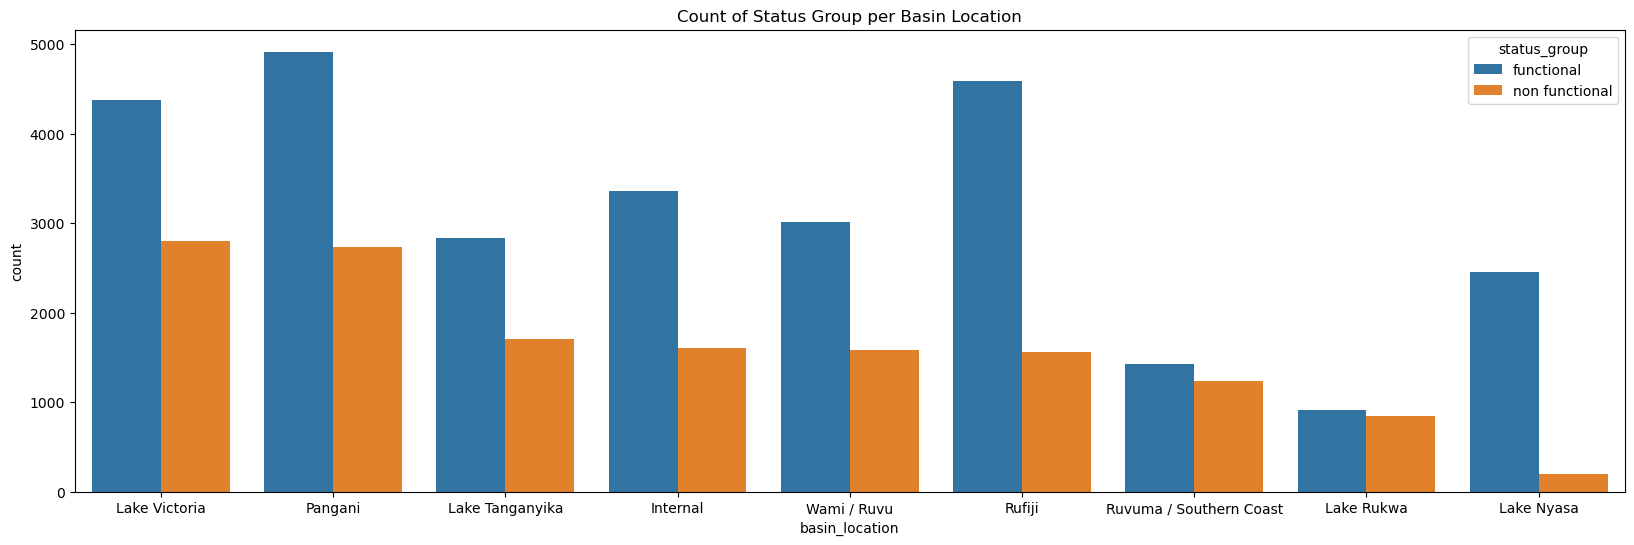

In [75]:
# Create a DataFrame with the count of each status_group within each basin_location
status_counts = train_values_df.groupby(['basin_location', 'status_group']).size().reset_index(name='counts')

# Sort the DataFrame based on the count of 'non functional' within each 'basin_location'
sorted_basins = status_counts[status_counts['status_group'] == 'non functional'].sort_values('counts', ascending=False)['basin_location']

# Convert the sorted basin names to a list
sorted_basins = sorted_basins.tolist()

# Create a categorical type with the basin names in the desired order
basin_order = pd.CategoricalDtype(sorted_basins, ordered=True)

# Convert the 'basin_location' column to this new categorical type
train_values_df['basin_location'] = train_values_df['basin_location'].astype(basin_order)

# Plot the data
plt.figure(figsize=(20,6))
sns.countplot(data=train_values_df, x='basin_location', hue='status_group')
plt.title('Count of Status Group per Basin Location')
plt.show()

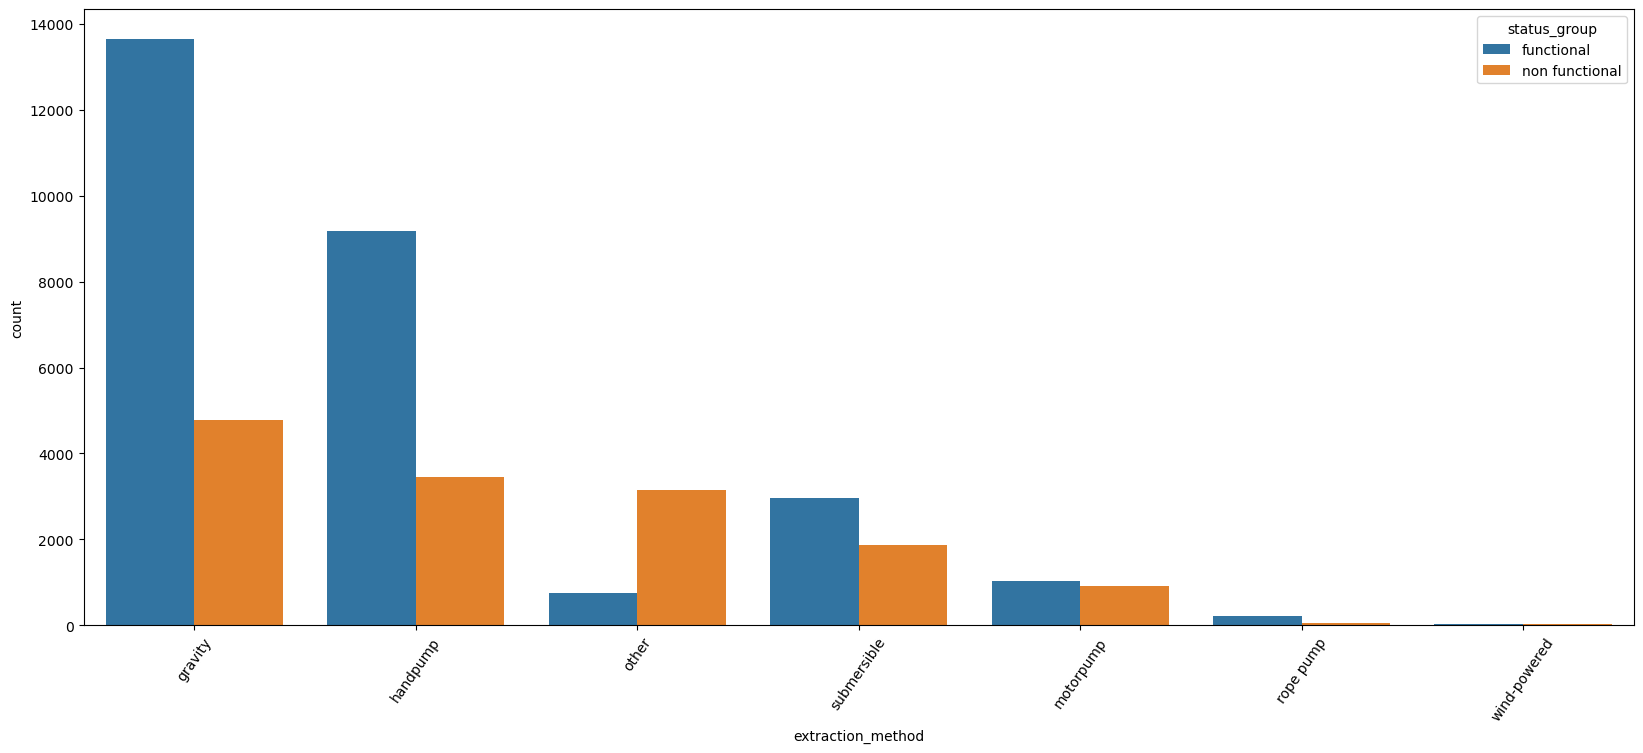

In [76]:
# Create a DataFrame that counts the 'status_group' values for each 'extraction_method'
grouped_df = train_values_df.groupby(['extraction_method', 'status_group']).size().unstack()

# Order 'extraction_method' by the count of 'non functional'
ordered_methods = grouped_df.sort_values('non functional', ascending=False).index

# Convert 'status_group' to a category and specify the order for 'extraction_method'
train_values_df['status_group'] = train_values_df['status_group'].astype('category')
train_values_df['extraction_method'] = pd.Categorical(train_values_df['extraction_method'], categories=ordered_methods, ordered=True)

plt.figure(figsize=(20, 8))
sns.countplot(data=train_values_df, x='extraction_method', hue='status_group')
plt.xticks(rotation=55)  # Rotate x labels for better visibility if needed
plt.show()

## Modeling

## Logistic Regression


In [77]:
# Establishing columns needed (df) for Logistic Regression
df = train_values_df[['total_static_head(ft)', 'height', 'population', 'source_class', 'permit_approved', 'extraction_method', 'quantity_of_water', 'status_group']]

# Which columns need to be converted
needs_dummied = ['source_class', 'permit_approved', 'extraction_method', 'quantity_of_water']



# Create dummy variables
dummies = pd.get_dummies(df[needs_dummied], prefix='needs_dummied')

# Concatenate the original DataFrame with the dummy DataFrame
df = pd.concat([df.drop(needs_dummied, axis=1), dummies], axis=1)



# Let's assume all other columns in your DataFrame are your features
X = df.drop('status_group', axis=1)

# The target column is 'status_group'
y = df['status_group']

# Encode the target to be '1' when 'functional' and '0' otherwise
y = (y == 'functional').astype(int)



# Now, before proceeding with the splitting, we use SMOTE to balance the classes
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)



# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)



scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



model = LogisticRegression()
model.fit(X_train, y_train)



predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.54      0.66      5546
           1       0.66      0.89      0.76      5605

    accuracy                           0.72     11151
   macro avg       0.75      0.72      0.71     11151
weighted avg       0.75      0.72      0.71     11151



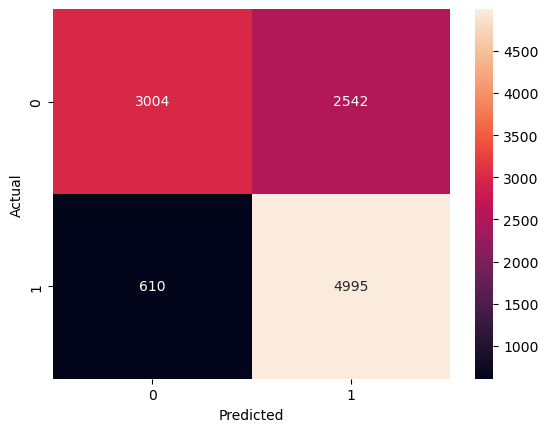

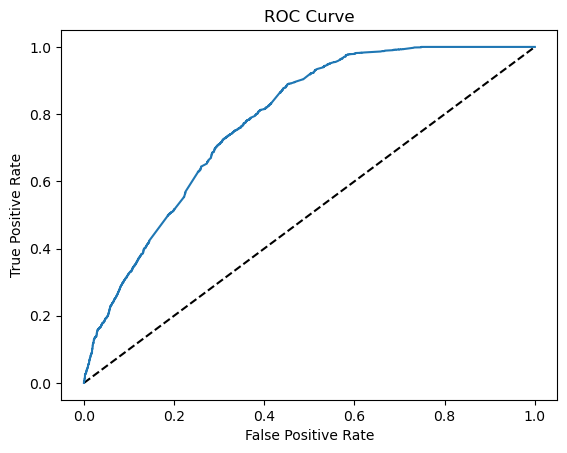

AUC Score: 0.7813206422450719


In [78]:
# Generate a confusion matrix
conf_mat = confusion_matrix(y_test, predictions)

# Using seaborn to visualize the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Generate the prediction probabilities
y_probs = model.predict_proba(X_test)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute Area Under the Curve (AUC) score
auc_score = auc(fpr, tpr)
print(f"AUC Score: {auc_score}")

## Decision Tree Modeling


In [79]:
train_values_df['status_group'] = train_values_df['status_group'].map({'functional': 1, 'non functional': 0})

In [80]:
train_values_df['status_group'].value_counts()

1    27876
0    14262
Name: status_group, dtype: int64

In [81]:
#One Hot Encode categorical features 
X = train_values_df.drop('status_group', axis=1)
y = train_values_df['status_group']

X_cats = X.select_dtypes(include='object')

ohe = OneHotEncoder(drop='first')
ohe.fit(X_cats)
X_cats_encoded = pd.DataFrame(ohe.transform(X_cats).todense(), columns=ohe.get_feature_names_out())

MemoryError: Unable to allocate 36.1 GiB for an array with shape (42138, 115055) and data type float64

In [ ]:
X_cats_encoded.shape

In [ ]:
#concat with numerical columns 
X_num = X.select_dtypes(exclude='object')
X_cats_encoded = X_cats_encoded.reset_index(drop=True)
X_num = X_num.reset_index(drop=True)

In [ ]:
X_processed = pd.concat([X_num, X_cats_encoded], axis=1)

In [ ]:

X_processed.shape

In [ ]:
#perform train-test split
X = X_processed
y = train_values_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
#fit decision tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

In [ ]:
#cross validation, using precision as our scoring metric 
from sklearn.model_selection import cross_val_score
cross_val_score(dt, X_train, y_train, cv=5, scoring='roc_auc')

In [ ]:
#train precision score 
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
train_y_preds = dt.predict(X_train)
print(precision_score(y_train, train_y_preds))
print(roc_auc_score(y_train, train_y_preds))

In [ ]:
#Find the depth of our current tree 
dt.get_depth()

# Address Overfitting

In [ ]:
#decision tree 2: tuning max depth 
dt2 = DecisionTreeClassifier(max_depth=50)
dt2.fit(X_train, y_train)

In [ ]:
#cross validation, using precision as our scoring metric 
from sklearn.model_selection import cross_val_score
cross_val_score(dt2, X_train, y_train, cv=5, scoring='f1')

In [ ]:
#experimenting with different max_depths
for i in [20, 30, 40, 50, 60, 70]:
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(X_train, y_train)
    scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='roc_auc')
    ave_auc = scores.mean()
    y_preds = tree.predict(X_train)
    train_auc = roc_auc_score(y_train, y_preds)
    print(f"max_depth: {i} \n scores: {scores} \n ave_auc: {ave_auc} \n train_auc: {train_auc}")

In [ ]:
#experimenting with different min_sample_splits
for i in [5, 10, 20, 50, 100, 150, 200]:
    tree = DecisionTreeClassifier(max_depth=30, min_samples_split=i)
    tree.fit(X_train, y_train)
    scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='roc_auc')
    ave_auc = scores.mean()
    y_preds = tree.predict(X_train)
    train_auc = roc_auc_score(y_train, y_preds)
    print(f"min_sample_splits: {i} \n scores: {scores} \n ave_auc: {ave_auc} \n train_auc: {train_auc}")

In [ ]:
#find out which features are most influential 
dt3 = DecisionTreeClassifier(max_depth=50, min_samples_split=5)
dt3.fit(X_train, y_train)

In [ ]:
#get feaure 
importances = dt3.feature_importances_
features = dt3.feature_names_in_

together = zip(features, importances)

togetherdf = pd.DataFrame(together, columns=['feature', 'importance'])

In [ ]:
togetherdf.sort_values('importance', ascending=False).head(20)

In [ ]:
togetherdf.head()

## Evaluate Model on Test Set

In [ ]:
#predict from X_test
y_preds = dt.predict(X_test)

In [ ]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

In [ ]:
recall = recall_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

print(f'recall: {recall}')
print(f'accuracy: {accuracy}')
print(f'f1: {f1}')